In [10]:
%reload_ext autoreload
%autoreload 2

from fastai import *
from fastai.vision import *
from pathlib import Path
import PIL
import cv2

from utils import FocalLoss, f1
from dark import *

torch.backends.cudnn.benchmark = True

In [11]:
MASKS = 'train.csv'

PATH = Path('./')

TRAIN = Path('train/')
TRAIN64 = Path('train64/')

TEST = Path('test/')

SAMPLE = Path('sample_submission.csv')

seg = pd.read_csv(PATH/MASKS)
sample_sub = pd.read_csv(PATH/SAMPLE)
train_names = list(seg.Id.values)
test_names = list(sample_sub.Id.values)

In [12]:
def open_image4d(path:PathOrStr)->Image:
    '''open RGBA image from 4 different 1-channel files.
    return: numpy array [4, sz, sz]'''
    path=str(path)
    flags = cv2.IMREAD_GRAYSCALE
    red = cv2.imread(path+ '_red.png', flags)
    blue = cv2.imread(path+ '_blue.png', flags)
    green = cv2.imread(path+ '_green.png', flags)
    yellow = cv2.imread(path+ '_yellow.png', flags)
    im = np.stack(([red, green, blue, yellow]))

    return Image(Tensor(im/255).float())

# def open_image4d(path:PathOrStr)->Image:
#     '''open RGBA image from a single 4-channel file
#     return: numpy array [4, sz, sz]'''
#     path=str(path)
#     flags = cv2.IMREAD_UNCHANGED
#     im = cv2.imread(path+ '.png', flags)
#     return Image(Tensor(np.rollaxis(im, 2, 0)/255).float())


In [13]:
fname = train_names[0]

In [14]:
%time im = open_image4d(TRAIN/fname); 

CPU times: user 16.6 ms, sys: 4.05 ms, total: 20.6 ms
Wall time: 34.1 ms


In [15]:
im.shape

torch.Size([4, 512, 512])

In [16]:
class Image4C_ds(ImageMultiDataset):
    def __init__(self, fns:FilePathList, labels:ImgLabels, classes:Optional[Collection[Any]]=None):
        super().__init__(fns, labels, classes)
    def __getitem__(self,i:int)->Tuple[Image, np.ndarray]: return open_image4d(self.x[i]), self.encode(self.y[i])
    def _get_x(self,i): return open_image4d(self.x[i])

In [17]:
from fastai.data_block import _df_to_fns_labels
fnames, labels = _df_to_fns_labels(seg, label_delim=' ', fn_col=0, label_col=1)
test_fnames, _ = _df_to_fns_labels(sample_sub, fn_col=0, label_col=1)

In [18]:
classes = uniqueify(np.concatenate(labels))

In [19]:
stats = ([0.485, 0.456, 0.406, 0.406], [0.229, 0.224, 0.225, 0.225])
norm,denorm = normalize_funcs(*stats)

In [20]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.2)

In [32]:
def get_data(sz=64, bs=64, is_test=False):
    folder=TRAIN
    test_ds=None
    if is_test: 
        t_names = [TEST/f for f in test_names]
        test_labels = [[classes[0]]] * len(test_names)
        test_ds = Image4C_ds(t_names, test_labels, classes)
    train, val = Image4C_ds.from_folder(PATH, folder, fnames, labels, valid_pct=0.2, classes=classes)
    return ImageDataBunch.create(train_ds=train, valid_ds=val, test_ds=test_ds,
                                 ds_tfms=tfms, tfms=norm, bs=bs, size=sz)


In [22]:
# train, val = Image4C_ds.from_folder(PATH, TRAIN, fnames, labels, valid_pct=0.2, classes=classes)

In [23]:
class_sample_count = array([12885,  1254,  3621,  1561,  1858,  2513,  1008,  2822,    53,
          45,    28,  1093,   688,   537,  1066,    21,   530,   210,
         902,  1482,   172,  3777,   802,  2965,   322,  8228,   328,
          11])
print(class_sample_count)

[12885  1254  3621  1561  1858  2513  1008  2822    53    45    28  1093   688   537  1066    21   530   210   902
  1482   172  3777   802  2965   322  8228   328    11]


In [24]:
# from torch.utils.data.sampler import WeightedRandomSampler
# wrs = WeightedRandomSampler(weight, len(weight))

In [25]:
arch = dark_small()

In [38]:
def get_learner(data, focal=False, fp16=False):
    learn = Learner(data, arch , wd=0.2, div_factor=10, pct_start=0.5, metrics=[accuracy_thresh, f1])
    if focal: learn.loss_func=FocalLoss()
    if fp16: learn.to_fp16();
    learn.load('dk_small_128')
    return learn.mixup()

In [39]:
data = get_data(128, 64, True)
learn = get_learner(data, focal=True, fp16=True)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


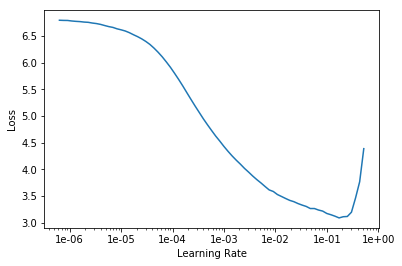

In [55]:
learn.lr_find()
learn.recorder.plot()

In [34]:
lr = 1e-3

In [40]:
%time learn.fit_one_cycle(10, lr/10)

Total time: 38:13
epoch  train_loss  valid_loss  accuracy_thresh  f1      
1      0.862431    0.834448    0.960202         0.502210  (03:49)
2      0.850548    0.811122    0.961104         0.539769  (03:49)
3      0.824977    0.815574    0.960713         0.558878  (03:48)
4      0.815702    0.802674    0.961448         0.563713  (03:49)
5      0.801287    0.794164    0.961822         0.561259  (03:49)
6      0.792575    0.779199    0.962678         0.573673  (03:49)
7      0.798355    0.769920    0.963057         0.580503  (03:49)
8      0.776772    0.762002    0.963401         0.583335  (03:49)
9      0.778438    0.761225    0.963476         0.583848  (03:49)
10     0.777961    0.757895    0.963625         0.586339  (03:49)

CPU times: user 21min 6s, sys: 15min 17s, total: 36min 24s
Wall time: 38min 13s


In [41]:
learn.save('dk_small_128')

# Validation and Preds

In [42]:
learn.data.test_dl.add_tfm(to_half)
learn.data.valid_dl.add_tfm(to_half)

In [43]:
p,t = learn.get_preds(is_test=True)

In [44]:
p.shape

torch.Size([11702, 28])

In [45]:
p_v, t_v = learn.get_preds()

In [46]:
p_v.shape

torch.Size([6218, 28])

In [47]:
def f1_np(y_pred, y_true, threshold=0.5):
    y_pred = (y_pred>threshold).astype(int)
    TP = (y_pred*y_true).sum(1)
    prec = TP/(y_pred.sum(1)+1e-7)
    rec = TP/(y_true.sum(1)+1e-7)
    res = 2*prec*rec/(prec+rec+1e-7)
    return res.mean()

In [48]:
p_v_s = p_v.sigmoid()

In [49]:
f1(p_v, t_v)

tensor(0.5863)

In [50]:
p_v_np, t_v_np = to_np(p_v_s), to_np(t_v)

In [51]:
f1_np(p_v_np, t_v_np)

0.5863391274230327

In [52]:
def f1_n(y_pred, y_true, thresh, n, default=0.5):
    threshold = default * np.ones(y_pred.shape[1])
    threshold[n]=thresh
    return f1_np(y_pred, y_true, threshold)

In [54]:
def find_thresh(y_pred, y_true):
    ths = []
    for i in range(y_pred.shape[1]):
        aux = []
        for th in np.linspace(0,1,100):
            aux += [f1_n(y_pred, y_true, th, i)]
        ths += [np.array(aux).argmax()/100]
    return np.array(ths)

In [89]:
x = np.linspace(0,1,100)

In [96]:
 y = np.array([f1_n(p_v_np, t_v_np, th, 2) for th in x])

In [97]:
import matplotlib.pyplot as plt

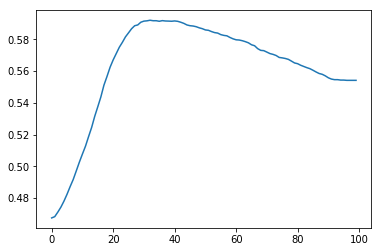

In [98]:
plt.plot(y)

In [55]:
ths = find_thresh(p_v_np, t_v_np)

In [56]:
ths

array([0.46, 0.4 , 0.32, 0.38, 0.4 , 0.37, 0.32, 0.4 , 0.33, 0.36, 0.34, 0.39, 0.41, 0.4 , 0.37, 0.32, 0.33, 0.39,
       0.35, 0.38, 0.44, 0.36, 0.32, 0.35, 0.36, 0.33, 0.31, 0.33])

In [87]:
f1_np(p_v_np, t_v_np, 0.42)

0.6527630210398663

# Sub File

In [58]:
preds = to_np(p.sigmoid())
threshold = ths
print(preds.shape)
classes = np.array(classes)
res = np.array([" ".join(classes[(np.where(pp>threshold))])for pp in preds])

(11702, 28)


In [69]:
classes

array(['16', '0', '7', '1', '2', '5', '18', '25', '23', '21', '24', '6', '11', '3', '12', '13', '14', '4', '20', '22',
       '17', '19', '8', '9', '10', '26', '27', '15'], dtype='<U2')

In [73]:
preds[1]

array([0.179099, 0.344885, 0.217504, 0.280912, 0.294418, 0.519537, 0.170784, 0.374333, 0.267982, 0.178812, 0.111241,
       0.294316, 0.225929, 0.338405, 0.091382, 0.148294, 0.104477, 0.252384, 0.120026, 0.124959, 0.1126  , 0.187728,
       0.073165, 0.020449, 0.009746, 0.129513, 0.02141 , 0.01698 ], dtype=float32)

In [59]:
res

array(['2', '5', '0 25', '0 25', ..., '0 19', '7', '1', '0 25'], dtype='<U19')

In [60]:
frame = pd.DataFrame(np.array([test_names, res]).T, columns = ['Id','Predicted'])
frame.to_csv('my_submission.csv', index=False)

In [62]:
frame.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,5
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 25
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0 25 23


In [61]:
#fix indexing
# f1 = pd.read_csv('sample_submission.csv')
# f1.drop('Predicted', axis=1, inplace=True)
# f2 = pd.read_csv('my_submission.csv')
# f1 = f1.merge(f2, left_on='Id', right_on='Id', how='outer')
# f1.to_csv('my_new_submission.csv', index=False)